<a href="https://colab.research.google.com/github/Divya-Chintala/Agentic_AI/blob/main/FineTuning_ClinicalBert_NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification
from datasets import Dataset
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np
import json



# Upload Input JSON files
from google.colab import files
uploaded = files.upload()

# Load and tokenize data
model_name = "emilyalsentzer/Bio_ClinicalBERT"

label_list = ['O', 'B-ExamName', 'I-ExamName', 'E-ExamName', 'S-ExamName',
              'B-clinicaldata', 'I-clinicaldata', 'E-clinicaldata', 'S-clinicaldata',
              'B-findings', 'I-findings', 'E-findings', 'S-findings',
              'B-impression', 'I-impression', 'E-impression', 'S-impression']

label2id = {l: i for i, l in enumerate(label_list)}
id2label = {i: l for l, i in label2id.items()}

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_labels(example):
    tokenized_inputs = tokenizer(
        example["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=256
    )
    labels = []
    word_ids = tokenized_inputs.word_ids()
    previous_word_idx = None
    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        else:
            labels.append(label2id[example["labels"][word_idx]])
        previous_word_idx = word_idx
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Load datasets
with open("train_merged.json") as f:
    train_data = Dataset.from_list(json.load(f))

with open("test_merged.json") as f:
    test_data = Dataset.from_list(json.load(f))

train_data = train_data.map(tokenize_labels)
test_data = test_data.map(tokenize_labels)

# Load model
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(label_list), id2label=id2label, label2id=label2id)

#  Set training arguments
args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=10,
    logging_dir="./logs",
    seed=42
)

#  Evaluation function
def compute_metrics(p):
    predictions, labels = p
    preds = np.argmax(predictions, axis=2)
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_preds = [[id2label[p] for (p, l) in zip(pred_row, label) if l != -100] for pred_row, label in zip(preds, labels)]
    y_true = [item for sublist in true_labels for item in sublist]
    y_pred = [item for sublist in true_preds for item in sublist]
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

#  Train
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_data,
    eval_dataset=test_data,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics
)

trainer.train()


Saving test_merged.json to test_merged.json
Saving train_merged.json to train_merged.json


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/789 [00:00<?, ? examples/s]

Map:   0%|          | 0/198 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2-2313667365.py:87: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: divyasaisree518 (divyasaisree518-illinois-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.037500,0.013853,0.997353,0.997372,0.997353,0.997356
2,0.006400,0.006419,0.998852,0.998856,0.998852,0.998853
3,0.004500,0.005432,0.999075,0.999078,0.999075,0.999076


TrainOutput(global_step=594, training_loss=0.12814189436585213, metrics={'train_runtime': 326.8089, 'train_samples_per_second': 7.243, 'train_steps_per_second': 1.818, 'total_flos': 309286649534976.0, 'train_loss': 0.12814189436585213, 'epoch': 3.0})

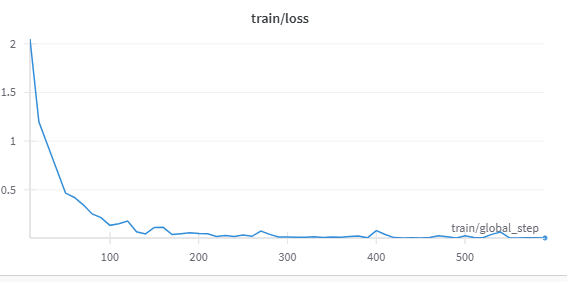

In [3]:
final_results = trainer.predict(test_data)
print(final_results.metrics)


{'test_loss': 0.005432080011814833, 'test_accuracy': 0.9990751961222016, 'test_precision': 0.9990783588993021, 'test_recall': 0.9990751961222016, 'test_f1': 0.9990757829072733, 'test_runtime': 3.1751, 'test_samples_per_second': 62.36, 'test_steps_per_second': 15.748}


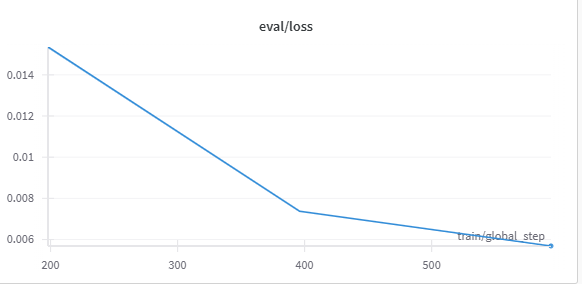

In [15]:
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer


model_path = "./trained_model"
model = AutoModelForTokenClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)


ner_pipeline = pipeline(
    "token-classification",
    model=model,
    tokenizer=tokenizer,
    aggregation_strategy="first"
)


sentence = input("\n\n Enter ReportText to be classified :  \n\n")


results = ner_pipeline(sentence)


for entity in results:
    print(f"\n{entity['word']} → {entity['entity_group']} ({entity['score']:.4f})")


Device set to use cuda:0




 Enter ReportText to be classified :  

EXAM: CHEST RADIOGRAPHY EXAM DATE: 06/03/2021 09:48 PM. CLINICAL HISTORY: CHEST PAIN. COMPARISON: XR CHEST 2 VIEWS 12/19/2017 11:13 AM. TECHNIQUE: 1 view. FINDINGS: Lungs/Pleura: No focal opacities evident. No pleural effusion. No pneumothorax. Mediastinum: Within exam limitations, the cardiomediastinal contour is normal. Other: None. IMPRESSION: Normal single view chest. 


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



exam : chest radiography exam date : 06 / 03 / 2021 09 : 48 pm → ExamName (0.9989)

. → ExamName (0.9974)

clinical history : chest pain → clinicaldata (0.9964)

. → clinicaldata (0.9942)

comparison : xr chest 2 views 12 / 19 / 2017 11 : 13 am → ExamName (0.9988)

. → ExamName (0.9962)

technique : 1 view → ExamName (0.9980)

. → ExamName (0.9979)

findings : lungs / pleura : no focal opacities evident. no pleural effusion. no pneumothorax. mediastinum : within exam limitations, the cardiomediastinal contour is normal. other : none → findings (0.9782)

. → findings (0.9924)

impression : normal single view chest → impression (0.9977)

. → impression (0.9946)


In [16]:

from collections import defaultdict

def merge_entities_by_group(entities):
    grouped = defaultdict(list)


    for ent in entities:
        grouped[ent["entity_group"]].append(ent)


    merged = {}
    for label, ents in grouped.items():
        ents_sorted = sorted(ents, key=lambda e: e.get("start", 0))
        merged_text = " ".join(e["word"] for e in ents_sorted)
        avg_score = sum(e["score"] for e in ents_sorted) / len(ents_sorted)
        merged[label] = (merged_text, avg_score)

    return merged

results = ner_pipeline(sentence)
merged = merge_entities_by_group(results)

for label, (text, score) in merged.items():
    print(f"{label}:\n{text} ({score:.4f})\n")


ExamName:
exam : chest radiography exam date : 06 / 03 / 2021 09 : 48 pm . comparison : xr chest 2 views 12 / 19 / 2017 11 : 13 am . technique : 1 view . (0.9979)

clinicaldata:
clinical history : chest pain . (0.9953)

findings:
findings : lungs / pleura : no focal opacities evident. no pleural effusion. no pneumothorax. mediastinum : within exam limitations, the cardiomediastinal contour is normal. other : none . (0.9853)

impression:
impression : normal single view chest . (0.9962)



In [18]:
import pandas as pd


Results_data = [
    {"Entity": label, "Text": text, "Confidence Score": round(score, 4)}
    for label, (text, score) in merged.items()
]

df = pd.DataFrame(Results_data)
df


,Entity,Text,Confidence Score
0,ExamName,exam : chest radiography exam date : 06 / 03 /...,0.9979
1,clinicaldata,clinical history : chest pain .,0.9953
2,findings,findings : lungs / pleura : no focal opacities...,0.9853
3,impression,impression : normal single view chest .,0.9962
